# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [3]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [4]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:

In [5]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'CONJ', 'PRT', 'VERB', 'PRON', 'X', 'NUM', 'NOUN', '.', 'DET', 'ADJ', 'ADP', 'ADV'}


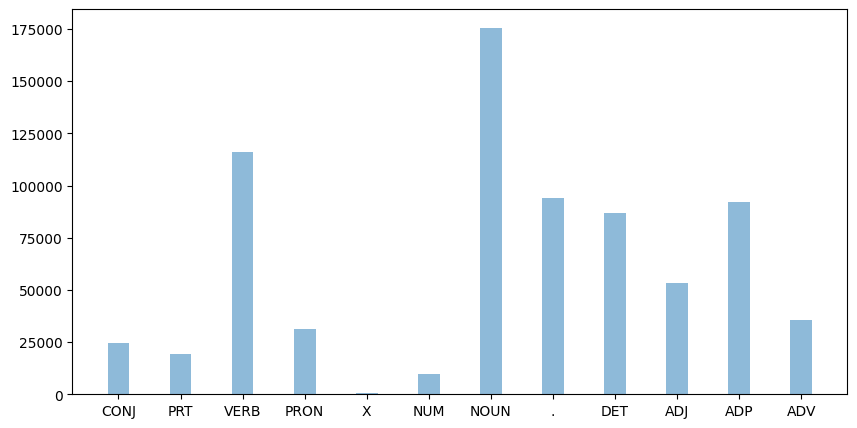

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)

plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [7]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.accuracy(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [8]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.accuracy(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [9]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.accuracy(test_data)))

Accuracy of trigram tagger = 23.33%


In [10]:
trigram_with_backoff_tagger = nltk.TrigramTagger(train_data, backoff=bigram_tagger)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_with_backoff_tagger.accuracy(test_data)))

Accuracy of trigram tagger = 93.43%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [11]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]

    return X, y

In [12]:
X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [13]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_indices = indices[start:end]

        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))

        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]

        yield X_batch, y_batch

In [52]:
def iterate_batches_for_pretrained(data, batch_size):
    X = [[word for word, _ in sample] for sample in data]
    y = [[tag for _, tag in sample] for sample in data]
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_indices = indices[start:end]

        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = []
        y_batch = np.zeros((max_sent_len, len(batch_indices)))

        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch.append(X[sample_ind])
            y_batch[:len(y[sample_ind]), batch_ind] = [tag2ind.get(tag, 0) for tag in y[sample_ind]]

        yield X_batch, y_batch

In [14]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [15]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeddings = self.word_embedding(inputs)
        lstm_result, _ = self.lstm(embeddings)
        tags = self.hidden2tag(lstm_result)
        scores = torch.softmax(tags, dim=-1)
        return scores

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [16]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

In [17]:
def calculate_accuracy(logits, targets):
    predictions = torch.argmax(logits, dim=2)
    mask = ~predictions.eq(0)
    accuracy = torch.sum((predictions == targets) * mask).item() / (targets.shape[0] * targets.shape[1])
    return accuracy

In [18]:
accuracy = calculate_accuracy(logits, y_batch)
print("Accuracy:", accuracy)

Accuracy: 0.015625


In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
def calculate_loss(logits, targets, criterion):
    return criterion(logits.view(-1, logits.shape[-1]), targets.view(-1))

In [21]:
loss = calculate_loss(logits, y_batch, criterion)
print("Loss:", loss.item())

Loss: 2.562805652618408


**Задание** Вставьте эти вычисление в функцию:

In [65]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None,
             pretrained=False):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0

    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)

    batches_count = math.ceil(len(data[0]) / batch_size)

    batches_iterator = (iterate_batches, iterate_batches_for_pretrained)[not is_train and pretrained]

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(batches_iterator(data, batch_size)):
                y_batch = LongTensor(y_batch)
                if is_train or not pretrained:
                    X_batch = LongTensor(X_batch)
                logits = model(X_batch)

                loss = calculate_loss(logits, y_batch, criterion)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                logits = logits.view(-1, logits.shape[-1])
                preds = torch.argmax(logits, dim=1)
                y_batch = y_batch.view(-1)

                if not pretrained:
                    mask = ~preds.eq(0)
                    cur_correct_count, cur_sum_count = torch.sum((preds == y_batch) * mask).item(), len(preds)
                else:
                    cur_correct_count, cur_sum_count = torch.sum(preds == y_batch).item(), len(preds)

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )

            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None, pretrained=False):

    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size

    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')

        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:', pretrained)

In [23]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=64)

[1 / 50] Train: Loss = 1.84029, Accuracy = 18.46%: 100%|██████████| 572/572 [00:07<00:00, 81.21it/s] 
[1 / 50]   Val: Loss = 1.78657, Accuracy = 21.99%: 100%|██████████| 101/101 [00:00<00:00, 231.65it/s]
[2 / 50] Train: Loss = 1.76902, Accuracy = 23.95%: 100%|██████████| 572/572 [00:04<00:00, 123.67it/s]
[2 / 50]   Val: Loss = 1.76681, Accuracy = 23.81%: 100%|██████████| 101/101 [00:00<00:00, 231.03it/s]
[3 / 50] Train: Loss = 1.75646, Accuracy = 25.05%: 100%|██████████| 572/572 [00:04<00:00, 121.90it/s]
[3 / 50]   Val: Loss = 1.76215, Accuracy = 23.83%: 100%|██████████| 101/101 [00:00<00:00, 227.65it/s]
[4 / 50] Train: Loss = 1.74894, Accuracy = 25.44%: 100%|██████████| 572/572 [00:04<00:00, 124.83it/s]
[4 / 50]   Val: Loss = 1.75154, Accuracy = 25.35%: 100%|██████████| 101/101 [00:00<00:00, 224.48it/s]
[5 / 50] Train: Loss = 1.74057, Accuracy = 26.47%: 100%|██████████| 572/572 [00:04<00:00, 120.27it/s]
[5 / 50]   Val: Loss = 1.74860, Accuracy = 25.45%: 100%|██████████| 101/101 [00:00

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [24]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    for X_batch_test, y_batch_test in iterate_batches((X_test, y_test), 64):
        X_batch_test, y_batch_test = torch.cuda.LongTensor(X_batch_test), torch.cuda.LongTensor(y_batch_test)
        logits = model(X_batch_test)
        predictions = torch.argmax(logits, dim=2)
        mask = ~predictions.eq(0)
        correct += torch.sum((predictions == y_batch_test) * mask).item()
        total += len(predictions.view(-1))
    return correct / total

In [25]:
lstm_accuracy = evaluate_model(model, X_test, y_test)

print("Base LSTM test accuracy is {:.2%}".format(lstm_accuracy))

Base LSTM test accuracy is 29.30%


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [26]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, word_emb_dim)
        self.dropout = nn.Dropout(0.25)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=True)
        self.hidden2tag = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        embeddings = self.word_embedding(inputs)
        embeddings_with_dropout = self.dropout(embeddings)
        lstm_result, _ = self.lstm(embeddings_with_dropout)
        tags = self.hidden2tag(lstm_result)
        scores = torch.softmax(tags, dim=-1)
        return scores

In [27]:
bi_model = BiLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(bi_model.parameters())

fit(bi_model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=64)

[1 / 50] Train: Loss = 1.83124, Accuracy = 18.73%: 100%|██████████| 572/572 [00:05<00:00, 100.58it/s]
[1 / 50]   Val: Loss = 1.78725, Accuracy = 21.80%: 100%|██████████| 101/101 [00:00<00:00, 200.31it/s]
[2 / 50] Train: Loss = 1.77349, Accuracy = 23.16%: 100%|██████████| 572/572 [00:05<00:00, 97.68it/s] 
[2 / 50]   Val: Loss = 1.77064, Accuracy = 23.42%: 100%|██████████| 101/101 [00:00<00:00, 200.60it/s]
[3 / 50] Train: Loss = 1.76172, Accuracy = 24.52%: 100%|██████████| 572/572 [00:05<00:00, 103.22it/s]
[3 / 50]   Val: Loss = 1.75468, Accuracy = 24.60%: 100%|██████████| 101/101 [00:00<00:00, 202.94it/s]
[4 / 50] Train: Loss = 1.75230, Accuracy = 25.28%: 100%|██████████| 572/572 [00:05<00:00, 97.96it/s] 
[4 / 50]   Val: Loss = 1.75336, Accuracy = 25.15%: 100%|██████████| 101/101 [00:00<00:00, 197.92it/s]
[5 / 50] Train: Loss = 1.75043, Accuracy = 25.63%: 100%|██████████| 572/572 [00:05<00:00, 103.03it/s]
[5 / 50]   Val: Loss = 1.75126, Accuracy = 24.86%: 100%|██████████| 101/101 [00:00

In [28]:
bi_lstm_accuracy = evaluate_model(bi_model, X_test, y_test)

print("Bidirectional LSTM test accuracy is {:.2%}".format(bi_lstm_accuracy))

Bidirectional LSTM test accuracy is 30.55%


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [29]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [30]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.key_to_index:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1

print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [43]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=True)
        self.embedding_dim = self.word_embedding.weight.shape[-1]
        self.dropout = nn.Dropout(0.25)
        self.lstm = nn.LSTM(self.embedding_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=True)
        self.hidden2tag = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        if self.training:
            embeddings = self.word_embedding(inputs)
        else:
            batch_size = len(inputs)
            max_sent_len = max(len(sent) for sent in inputs)
            embeddings = self.word_embedding.weight.new_zeros((max_sent_len, batch_size, self.embedding_dim))
            for i, sent in enumerate(inputs):
                for j, word in enumerate(sent):
                    if word in w2v_model.key_to_index:
                        embeddings[j, i] = torch.from_numpy(w2v_model.get_vector(word))
        embeddings_with_dropout = self.dropout(embeddings)
        lstm_result, _ = self.lstm(embeddings_with_dropout)
        outputs = self.hidden2tag(lstm_result)
        return outputs

In [66]:
new_model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(new_model.parameters())

fit(new_model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=val_data, val_batch_size=64, pretrained=True)

[1 / 50] Train: Loss = 0.46160, Accuracy = 27.10%: 100%|██████████| 572/572 [00:04<00:00, 123.97it/s]
[1 / 50]   Val: Loss = 69.17860, Accuracy = 25.46%: : 101it [00:02, 34.86it/s]
[2 / 50] Train: Loss = 0.11139, Accuracy = 30.21%: 100%|██████████| 572/572 [00:04<00:00, 123.13it/s]
[2 / 50]   Val: Loss = 71.25201, Accuracy = 24.97%: : 101it [00:03, 30.49it/s]
[3 / 50] Train: Loss = 0.07795, Accuracy = 30.54%: 100%|██████████| 572/572 [00:04<00:00, 126.09it/s]
[3 / 50]   Val: Loss = 69.81128, Accuracy = 25.40%: : 101it [00:02, 34.73it/s]
[4 / 50] Train: Loss = 0.06108, Accuracy = 30.74%: 100%|██████████| 572/572 [00:04<00:00, 123.58it/s]
[4 / 50]   Val: Loss = 75.09033, Accuracy = 25.68%: : 101it [00:03, 28.34it/s]
[5 / 50] Train: Loss = 0.04983, Accuracy = 30.94%: 100%|██████████| 572/572 [00:04<00:00, 124.76it/s]
[5 / 50]   Val: Loss = 73.89227, Accuracy = 25.21%: : 101it [00:03, 29.12it/s]
[6 / 50] Train: Loss = 0.04239, Accuracy = 30.94%: 100%|██████████| 572/572 [00:04<00:00, 127.6

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [67]:
def evaluate_pretrained_model(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    for X_batch_test, y_batch_test in iterate_batches_for_pretrained(test_data, 64):
        y_batch_test = torch.cuda.LongTensor(y_batch_test)
        logits = model(X_batch_test)
        predictions = torch.argmax(logits, dim=2)
        correct += torch.sum(predictions == y_batch_test).item()
        total += len(predictions.view(-1))
    return correct / total

In [68]:
pretrained_lstm_accuracy = evaluate_pretrained_model(new_model, X_test, y_test)

print("Pretrained LSTM test accuracy is {:.2%}".format(pretrained_lstm_accuracy))

Pretrained LSTM test accuracy is 24.22%


Сохраним лучшую модель

In [69]:
torch.save(bi_model, "models/bidirectional_lstm.pth")